# V.1 Exploring the green reds

# a) Write a function that will plot a scatterplot matrix

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def plot_scatter_matrix(wine_data, good_threshold, bad_threshold, save_plot=False):
    # pandas read csv as DataFrame
    df = pd.read_csv(wine_data, delimiter=";")
    # Convert dataframe value to array
    data = df.values
    # get data & variable number
    numdata, numvar = data.shape

    # output two objects, whole plot fig and a set of subplot axes 
    fig, axes = plt.subplots(nrows=numvar, ncols=numvar, figsize=(24,24))
    # close space between subplot
    fig.subplots_adjust(hspace=0, wspace=0)

    # Hide all ticks and labels
    for ax in axes.flat:
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

    # upper triangle coordinate
    tri_upper = []
    for row in range(numvar):
        for col in range(row + 1, numvar):
            tri_upper.append([row, col])

    # change quality value to color list
    cq = []
    for i in range(numdata):
        if (df['quality'].values[i] >= good_threshold):
            cq.append('green')
        elif (df['quality'].values[i] <= bad_threshold):
            cq.append('red')
        else:
            cq.append('none')
        
    # Plot the data
    for i, j in tri_upper:
        for x, y in [(i,j), (j, i)]:
            axes[x,y].scatter(data[:,y % numvar], data[:,x % numvar], s=3, c=cq)

    # Label the diagonal subplots...
    names = df.columns.values
    for i, label in enumerate(names):
        axes[i,i].annotate(label, (0.5, 0.5), xycoords='axes fraction', ha='center', va='center', size=12)

    # show fig
    fig.show()
    if (save_plot == True):
        fig.savefig('scatter_matrix.png')

/Users/42robotics/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


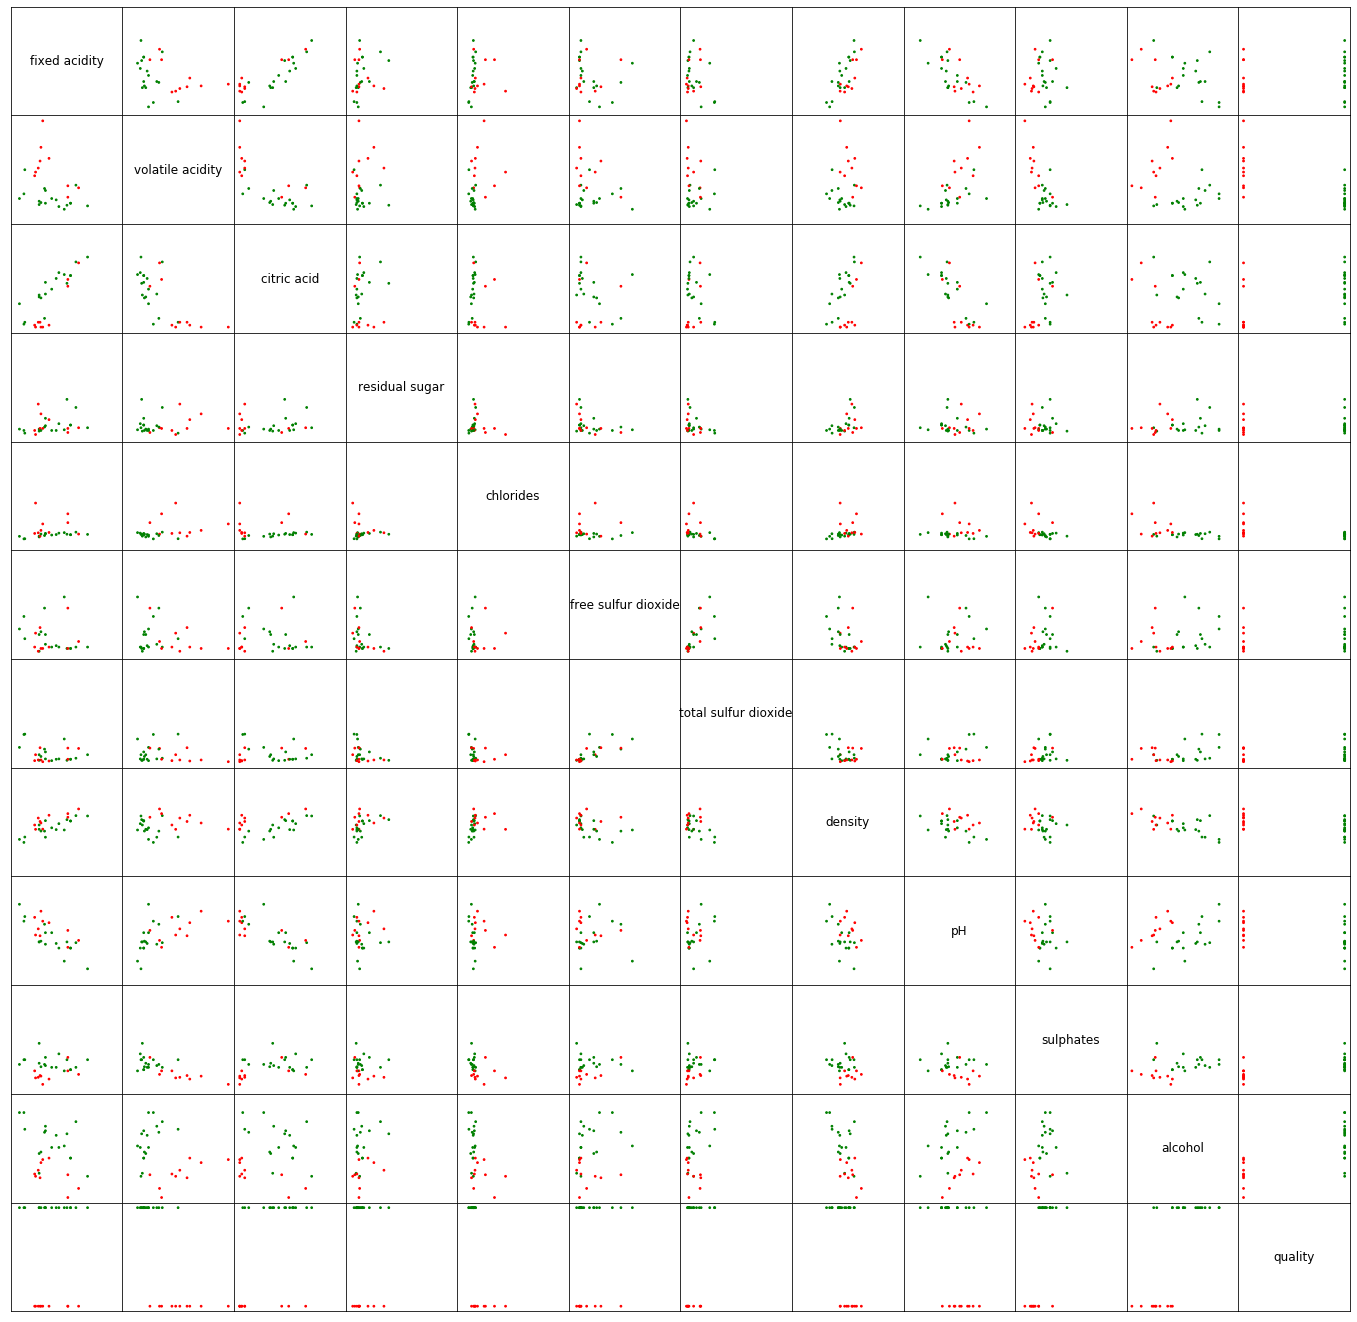

In [3]:
plot_scatter_matrix('winequality-red.csv', 8, 3, True)

# Referance

Basic Panda: https://ithelp.ithome.com.tw/articles/10191588<br>
make scattorplot matrix: https://stackoverflow.com/questions/7941207/is-there-a-function-to-make-scatterplot-matrices-in-matplotlib<br>
zip() in GeeksforGeeks: https://www.geeksforgeeks.org/zip-in-python/<br>
save plot: https://pythonspot.com/matplotlib-save-figure-to-image-file/<br>

## Doc

matplotlib.pyplot.scatter: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.scatter.html#matplotlib.pyplot.scatter<br>
matplotlib.pyplot.subplots: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplots.html<br> matplotlib.figure.Figure: https://matplotlib.org/api/_as_gen/matplotlib.figure.Figure.html<br>
numpy.triu_indices_from: https://docs.scipy.org/doc/numpy/reference/generated/numpy.triu_indices_from.html<br>
matplotlib.pyplot.annotate: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.annotate.html<br>

# b)  Question:
Now that you’ve had a chance to analyze different chemical factors in red wines and their relationship with high scores (8 or higher) and low scores (3 or lower), which factors do you think will be most useful to your perceptron for distinguishing high quality vs. low quality wines? Why?

# Answer:
I assume if the factors can be seperate good and bad by eyes, that's a useful factor to distinguish wine quality.<br>
<br>
My observation as follow:<br>
pH & alcohol / alcohol & volatile acidity / density & citric acid<br>

# V.2 Learning to perceptron

## a) & b) Perceptron Implementation

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import sys
import math

In [5]:
def build_data(df, factors, good_thresh, bad_thresh):
    # Only catch data over or below threshold
    for i in range(len(df)):
        if (df.loc[i, 'quality'] < good_thresh and df.loc[i, 'quality'] > bad_thresh):
            df = df.drop([i])
    # build dataFrame
    df = df[factors]
    return df
    
def build_target(df, good_thresh, bad_thresh, value=[1, 0]):
    # Only catch data over or below threshold, and transfer to 1 & 0
    for i in range(len(df)):
        if (df.loc[i, 'quality'] >= good_thresh):
            df.loc[i, 'quality'] = value[0]
        elif (df.loc[i, 'quality'] <= bad_thresh):
            df.loc[i, 'quality'] = value[1]
        else:
            df = df.drop([i])
    # build dataFrame
    target = pd.DataFrame(df['quality'].values, columns=['target'])    
    df = df['quality']
    return (df)

def build_dataset(wine_data, factors, good_thresh, bad_thresh, value=[1, 0]):
    # pandas read csv as DataFrame
    df = pd.read_csv(wine_data, delimiter=";")
    data = build_data(df, factors, good_thresh, bad_thresh)
    target = build_target(df, good_thresh, bad_thresh, value)
    return data.reset_index(drop=True), target.reset_index(drop=True)

In [6]:
class ANN: 
    def ft_arrayDotList(self, a, l):
        size = a.shape[0]
        re = [0 for i in range(size)]
        for i in range(size):
            re[i] = self.getNetValue(a[i], l)
        return pd.DataFrame([re]).values[0]
    
    def getNetValue(self, s1, s2):
        net = 0;
        for i in range(len(s1)):
            net += s1[i] * s2[i]
        return net

    def ft_transpose(self, m1):
        df = pd.DataFrame(m1)
        new = []
        for col in range(m1.shape[1]):
            new.append(df.iloc[:, col].values)
        return pd.DataFrame(new).values

In [7]:
class Perceptron(ANN):
    def __init__(self, lr, epoch):
        ANN.__init__(self)
        self.lr = lr
        if (epoch <= 0):
            epoch = sys.maxsize
        self.epoch = epoch
        
    def train(self, data, target, verbose = True):
        curEpoch = 0
        performance = []
        self.weight = [random.uniform(-1, 1) for i in range(data.shape[1] + 1)]
        # Start training
        for _ in range(self.epoch):
            epochError = 0
            # Update weight
            for xi, yi in zip(data, target):
                deltaW = self.lr * (yi - self.predict(xi))
                self.weight[0] += deltaW
                self.weight[1:] += deltaW * xi
                epochError += int(deltaW != 0.0)
            # record performance
            curEpoch += 1
            performance.append((curEpoch, epochError, self.weight))
            if (verbose == True):
                print(f"Training preceptron, curEpoch: {curEpoch}, errorNumber: {epochError}")
            if ((self.epoch == sys.maxsize and epochError <= 0) or (curEpoch > 20000)):
                break
        return performance

    def predict(self, x):
        return 1 if self.activation(x) >= 0.0 else 0
    
    def activation(self, x):
        return self.getNetValue(self.weight[1:], x) + self.weight[0]

## c) Generate performance plot

In [8]:
def draw_number_of_errors(ax, performance, epoch):
    # epoch error check
    if (epoch == -1):
        epoch = len(performance)
    
    # set scatter plot x and y
    er = []
    ep = []
    for i in range(epoch):
        ep.append(performance[i][0])
        er.append(performance[i][1])
    
    # draw scatter plot
    ax[0].plot(ep, er, label='Errors as a function of epoch')
    ax[0].set(xlabel='Epoch', ylabel='Error')
    ax[0].set_title('Errors as a function of epochs')

def draw_decision_boundary(ax, data, performance, epoch):
    # set boundary
    x_min = data.iloc[:,0].min()
    x_max = data.iloc[:,0].max()
    y_min = data.iloc[:,1].min()
    y_max = data.iloc[:,1].max()
    x_rg = x_max - x_min
    y_rg = y_max - y_min
    ax[1].set_xlim([x_min - 0.05 * x_rg, x_max + 0.05 * x_rg])
    ax[1].set_ylim([y_min - 0.05 * y_rg, y_max + 0.05 * y_rg])
    
    # get decision boundary line equation
    wx = performance[epoch][2][1]
    wy = performance[epoch][2][2]
    b = performance[epoch][2][0]
    slope = -wx/wy
    intercept = -b/wy
    x_coords = range(int(x_min) - 1, int(x_max) + 2)
    y_coords = slope * x_coords + intercept
    
    # draw Drecision boundary
    ax[1].plot(x_coords, y_coords, 'b--', label='Decision boundary')
    ax[1].fill_between(x_coords, y_coords, y_min - 0.05 * y_rg, color='pink')
    ax[1].fill_between(x_coords, y_coords, y_max + 0.05 * y_rg, color='palegreen')
    
def draw_scatter_plot(ax, data, target, epoch, good_thresh, bad_thresh):
    # Join data and target, split good and bad wine data
    wine_data = pd.DataFrame(data.values)
    wine_data.insert(2, 'target', target.values)
    good_wine = wine_data[(wine_data['target'] > 0)]
    bad_wine = wine_data[(wine_data['target'] <= 0)]
    
    # draw
    ax[1].scatter(good_wine.iloc[:,0].values,good_wine.iloc[:,1].values, c='green', s=10, label=f'good wines (> {good_thresh} score)')
    ax[1].scatter(bad_wine.iloc[:,0].values,bad_wine.iloc[:,1].values, c='red', s=10, label=f'bad wines (< {bad_thresh} score)')
    ax[1].set(xlabel=data.columns[0], ylabel=data.columns[1])
    ax[1].set_title(f'Decision boundary at epoch {epoch}')
    ax[1].legend(bbox_to_anchor=(1, 1), loc='upper left')

def draw_cost_plot(performance, data, epoch, save_plot=False):
    # epoch error check
    if (epoch == -1):
        epoch = len(performance)
    
    # set scatter plot x and y
    er = []
    ep = []
    for i in range(epoch):
        ep.append(performance[i][0])
        er.append(performance[i][3])
    
    # draw scatter plot
    plt.plot(ep, er)
    plt.xlabel("Epoch")
    plt.ylabel("Cost")
    plt.title("Cost of epoch")
    
    plt.show()
    if (save_plot):
        fig.savefig("Cost Plot: " + data.columns[0] + " & " + data.columns[1])

def plot_performace(performance, data, target, good_thresh, bad_thresh, epoch=-1, save_plot=False):
    # set subplot
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
     
    # some epoch error check
    if (epoch > len(performance)):
        epoch = len(performance)
    
    # draw
    draw_number_of_errors(ax, performance, epoch)
    draw_decision_boundary(ax, data, performance, epoch)
    draw_scatter_plot(ax, data, target, performance[epoch][0], good_thresh, bad_thresh)

    fig.show()
    
    if (save_plot):
        fig.savefig("Performance Plot: " + data.columns[0] + " & " + data.columns[1])

/Users/42robotics/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:92: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


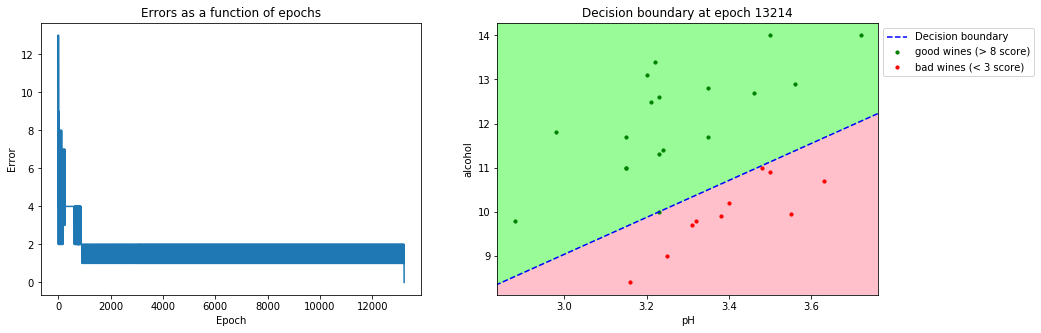

In [9]:
data , target = build_dataset("winequality-red.csv", ['pH', 'alcohol'], 8, 3)
precep = Perceptron(1, 0)
performance = precep.train(data.values, target.values, verbose=False)
plot_performace(performance, data, target, 8, 3, -1, True)

## d) modify the red wine data to help the perceptron learn more efficient

In [10]:
def getMean(xj):
    return sum(xj) / len(xj)

def getStdDev(xj):
    mu = getMean(xj)
    se = (xj - mu)**2
    sse = sum(se)
    return math.sqrt(sse / (len(xj) - 1))

def standardization(data):
    new = pd.DataFrame()
    for col in range(data.shape[1]):
        xj = data.iloc[:,col].values
        std_xj = (xj - getMean(xj)) / getStdDev(xj)
        new[data.columns[col]] = std_xj
    return new

def meanNormalization(data):
    new = pd.DataFrame()
    for col in range(data.shape[1]):
        xj = data.iloc[:,col].values
        xj_min = min(xj)
        xj_max = max(xj)
        xj_mean = getMean(xj)
        new[data.columns[col]] = (xj - xj_mean) / (xj_max - xj_min)
    return new

/Users/42robotics/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:92: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


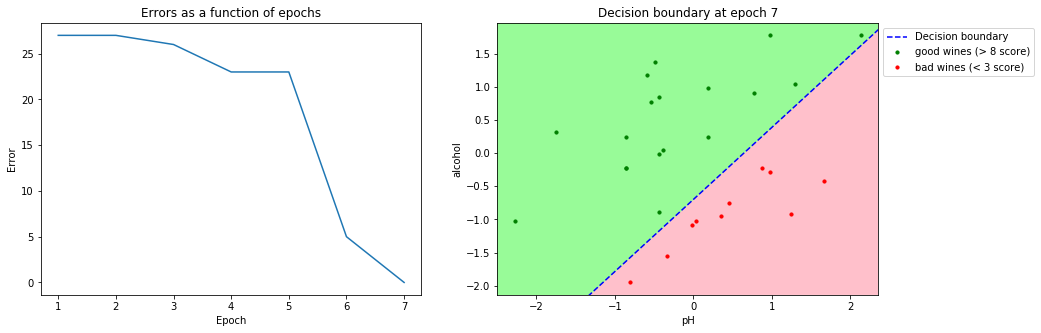

In [11]:
data , target = build_dataset("winequality-red.csv", ['pH', 'alcohol'], 8, 3)
std_data = standardization(data)
precep = Perceptron(0.01, 0)
performance = precep.train(std_data.values, target.values, verbose=False)
plot_performace(performance, std_data, target, 8, 3, -1, True)

# Referance
## Perceptron

Perceptron basic: https://towardsdatascience.com/what-the-hell-is-perceptron-626217814f53<br>
Perceptron algorithm: https://towardsdatascience.com/perceptron-learning-algorithm-d5db0deab975<br>
19-line Line-by-line Python Perceptron: https://medium.com/@thomascountz/19-line-line-by-line-python-perceptron-b6f113b161f3<br>
The Perception Learning Rule - Tutorial: http://uni-obuda.hu/users/fuller.robert/perception.pdf<br>

## Python

Find the Angle Between Two Vectors: https://www.wikihow.com/Find-the-Angle-Between-Two-Vectors<br>
law of cosines: https://www.mathopenref.com/lawofcosinesproof.html<br>
Pandas Data Selection: https://www.shanelynn.ie/select-pandas-dataframe-rows-and-columns-using-iloc-loc-and-ix/<br>
loading, editing, and viewing data: https://www.shanelynn.ie/using-pandas-dataframe-creating-editing-viewing-data-in-python/<br>
iter row in DataFrame: https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas<br>
pandas iteration: https://www.tutorialspoint.com/python_pandas/python_pandas_iteration.htm<br>
Joining DataFrames in Pandas: https://www.datacamp.com/community/tutorials/joining-dataframes-pandas<br>

## Plot

Graph plotting: https://www.geeksforgeeks.org/graph-plotting-in-python-set-1/<br>
Plot Straight line: https://scriptverse.academy/tutorials/python-matplotlib-plot-straight-line.html<br>
Legend guide: https://matplotlib.org/tutorials/intermediate/legend_guide.html<br>

## Doc

pandas insert: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.insert.html<br>
pandas.DataFrame: https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.html<br>
pandas.DataFrame.drop: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html<br>
pandas.DataFrame.dot: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dot.html<br>
pandas.DataFrame.add: http://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.add.html<br>

# V.3 My fair ADALINE

## a) Marvin notices and chides you for torturing your perceptron. Why?
Frank Rosenblatt proved mathematically that the perceptron learning rule converges if the two classes can be separated by a linear hyperplane. However, if classes cannot be separated perfectly by such a linear decision boundary, the weights will never stop updating unless we set a maximum number of epochs.

## b) & C) implement ADALINE

In [12]:
class Adaline(ANN):
    
    def __init__(self, lr, epoch, accu):
        ANN.__init__(self)
        self.lr = lr
        if (epoch <= 0):
            epoch = sys.maxsize
        self.epoch = epoch
        self.accu = accu
    
    def train(self, data, target, verbose=True, online=False):
        data_size = len(data)
        curEpoch = 0
        performance = []
        self.weight = [0.0001 * random.uniform(-1, 1) for i in range(data.shape[1] + 1)]
        # Start training
        for _ in range(self.epoch):
            net_epoch = []
            error_epoch = []
            errorNumber = 0
            # update weight by batch
            for xi, yi in zip(data, target):
                netInput = self.net_input(xi)
                error = yi - netInput
                error_epoch.append(error)
                net_epoch.append(netInput)
                if (online == True):
                    self.weight[0] += self.lr * error
                    self.weight[1:] += self.lr * (xi * error)
            if (online == False):
                self.weight[0] += self.lr * sum(error_epoch)
                self.weight[1:] += self.lr * self.ft_arrayDotList(self.ft_transpose(data), error_epoch)
            # calculate cost
            for i in range(len(error_epoch)):
                error_epoch[i] = error_epoch[i] ** 2
            cost = sum(error_epoch) / 2
            # record performance
            errorNumber = self.errorCount(net_epoch, target);
            curEpoch += 1
            status = self.StopCondition(curEpoch, performance, data_size, verbose)
            performance.append((curEpoch, errorNumber, self.weight, cost, status))
            if (self.epoch == sys.maxsize and status != 0):
                break
        return performance
    
    def StopCondition(self, curEpoch, performance, data_size, verbose):
        """
        return:
        0: not stop yet
        1: reach target accuracy
        2: take too much epochs
        -1: diverge
        """
        if (curEpoch > 2):
            accuracy = 1 - (performance[-1][1] / data_size)
            # if cost rising more then 10%
            if (performance[-2][3]/performance[-1][3] < 0.9):
                if (verbose == True):
                    print(f"Model diverge at curEpoch: {curEpoch}, accuracy: {accuracy:3f}, errorNumber: {performance[-1][1]}") 
                return -1
            # if reach 95% accuracy
            if (accuracy > self.accu):
                if (verbose == True):
                    print(f"Model converge at curEpoch: {curEpoch}, accuracy: {accuracy:3f}, errorNumber: {performance[-1][1]}") 
                return 1
            # if taking too much epoch
            if (curEpoch > 10000):
                if (verbose == True):
                    print(f"Training over {curEpoch} epochs, accuracy: {accuracy:3f}, errorNumber: {performance[-1][1]}") 
                return 2
            # print(f"curEpoch: {curEpoch}, errorNumber: {performance[-1][1]}, accuracy: {accuracy: 3f}") 
        return 0
    
    def net_input(self, x):
        return self.getNetValue(x, self.weight[1:]) + self.weight[0]

    def activation(self, x):
        return self.net_input(x)
    
    def errorCount(self, net, target):
        count = 0
        for i in range(len(net)):
            if ((target[i] >= 0 and net[i] < 0) or (target[i] < 0 and net[i] >= 0)):
                count += 1
        return count
    
    def predict(self, x):
        return 1 if self.net_input(x) > 0 else -1

In [32]:
data , target = build_dataset("winequality-red.csv", ['pH', 'alcohol'], 7, 4, value=[1, -1])

In [29]:
data = standardization(data)

Model converge at curEpoch: 918, accuracy: 0.853571, errorNumber: 41


/Users/42robotics/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:92: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


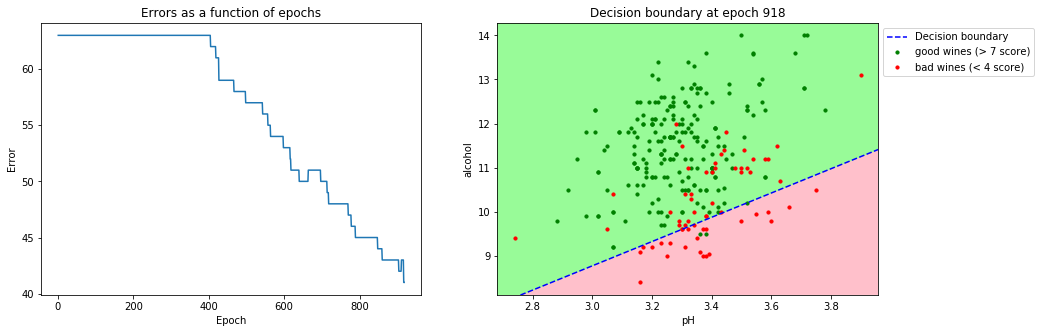

In [35]:
ada1 = Adaline(0.00005, 0, 0.85)
performance = ada1.train(data.values, target.values, verbose=True, online=False)
plot_performace(performance, data, target, 7, 4, -1, save_plot=True)

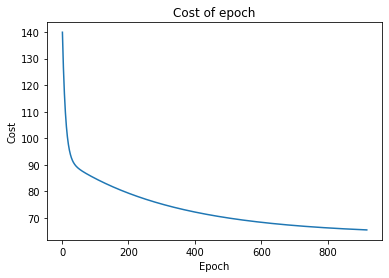

In [36]:
draw_cost_plot(performance, data, -1, save_plot=False)

## d) Find a good learning rate for your ADALINE

In [37]:
def Adaline_find_learning_rate(data, target, accu, loop, lr_max, lr_min, verbose=False):
    re_lr = 1
    re_epoch = 10000
    accuracy = 0
    data_size = len(data)

    for i in range(loop):
        lr = random.uniform(lr_max, lr_min)
        ada1 = Adaline(lr, 0, accu)
        if (verbose):
            print(f"Round: {i}, learning rate:{lr:.7f}", end = "...")
        performance = ada1.train(data.values, target.values, verbose=True, online=False)
        accuracy = 1 - (performance[-1][1] / data_size)
        # Successfully converge, record performance
        if (accuracy > accu and performance[-1][0] <= re_epoch):
            best_performance = performance
            re_lr = lr
            re_epoch = performance[-1][0]
        # taking too much epoch, higher min boundary
        elif (performance[-1][4] == 2):
            lr_min = lr
        # Diverge, lowe`r max boundary
        elif (performance[-1][4] == -1):
            lr_max = lr
    print(f"--------------------------------------------------------------")
    print(f"learning rate searching complete, searching result:")
    print(f"best learning rate: {re_lr: .7f}, epoch taken: {re_epoch}, accuracy: {1 - (best_performance[-1][1] / data_size):.3f}")
    return re_lr, best_performance

Round: 0, learning rate:0.0092058...Model diverge at curEpoch: 3, accuracy: 0.867857, errorNumber: 37
Round: 1, learning rate:0.0004529...Model converge at curEpoch: 3, accuracy: 0.867857, errorNumber: 37
Round: 2, learning rate:0.0058151...Model converge at curEpoch: 3, accuracy: 0.867857, errorNumber: 37
Round: 3, learning rate:0.0062859...Model converge at curEpoch: 3, accuracy: 0.867857, errorNumber: 37
Round: 4, learning rate:0.0023522...Model converge at curEpoch: 3, accuracy: 0.867857, errorNumber: 37
Round: 5, learning rate:0.0035244...Model converge at curEpoch: 3, accuracy: 0.867857, errorNumber: 37
Round: 6, learning rate:0.0049548...Model converge at curEpoch: 3, accuracy: 0.867857, errorNumber: 37
Round: 7, learning rate:0.0048074...Model converge at curEpoch: 3, accuracy: 0.867857, errorNumber: 37
Round: 8, learning rate:0.0019697...Model converge at curEpoch: 3, accuracy: 0.867857, errorNumber: 37
Round: 9, learning rate:0.0056918...Model converge at curEpoch: 3, accurac

/Users/42robotics/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:92: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


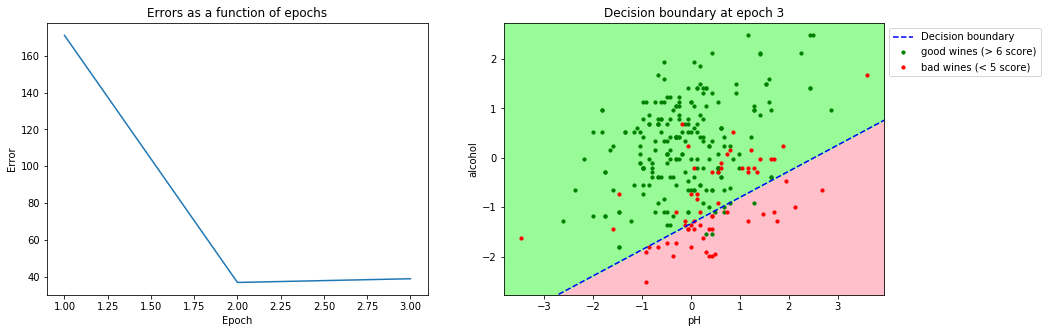

In [38]:
data , target = build_dataset("winequality-red.csv", ['pH', 'alcohol'], 7, 4, value=[1, -1])
data = standardization(data)
best_lr, best_performance = Adaline_find_learning_rate(data, target, 0.8, 30, 0.01, 0.00001, verbose=True)
plot_performace(best_performance, data, target, 6, 5, -1, save_plot=True)

# Referance
Perceptron, Adaline, and neural network: https://sebastianraschka.com/faq/docs/diff-perceptron-adaline-neuralnet.html<br>
Gradient Descent Rule for Linear Regression and Adaline: http://rasbt.github.io/mlxtend/user_guide/general_concepts/linear-gradient-derivative/<br>
Gradient Descent and Stochastic Gradient Descent: http://rasbt.github.io/mlxtend/user_guide/general_concepts/gradient-optimization/<br>
機器學習(3)--適應線性神經元與梯度下降法(Adaline neuron and Gradient descent): http://arbu00.blogspot.com/2017/02/3-adaline-neuron-and-gradient-descent.html<br>
The "Python Machine Learning (1st edition)" book code repository and info resource: https://github.com/rasbt/python-machine-learning-book<br>
人工神經網路(1)--使用Python實作perceptron(感知器): http://arbu00.blogspot.com/2016/11/1-pythonperceptron.html<br>
機器學習(4)--資料標準常態化與隨機梯度下降法( standardization & Stochastic Gradient descent): http://arbu00.blogspot.com/2017/02/4-standardization-stochastic-gradient.html<br>
Gradient Descent in a Nutshell: https://towardsdatascience.com/gradient-descent-in-a-nutshell-eaf8c18212f0<br>

# V.4 Advanced wine sampling and resampling

## a) Write a function that uses the holdout method to partition the red wine data into a training and a validation set.

In [39]:
def hold_out_dataset(data, target, split):
    com = data.join(target)
    train_set = com.sample(frac=split)
    test_set = com.drop(train_set.index)
    return train_set, test_set

## b) Write a function that generates a k-fold cross-validation dataset from the red wine data.

In [40]:
def k_fold_dataset(data, target, k):
    kset = []
    k_fold_dataset = []
    # Shuffle    
    com = data.join(target)
    com = com.sample(frac=1).reset_index(drop=True)
    klen = int(len(com)/k)
    # Split k fold
    for i in range(k):
        kset.append(com.iloc[i * klen:(i + 1) * klen])
    # Store k fold dataset
    for i in range(k):
        km1 = pd.DataFrame()
        for x in range(k):
            if (x != i):
                km1 = km1.append(kset[x])
        k_fold_dataset.append((km1, kset[i]))
    return k_fold_dataset

## c) k-fold cross-validation

In [41]:
def k_fold_cross_validation(k_fold_dataset, classifier, plot, _online):
    result = []
    
    for k in range(len(k_fold_dataset)):
        # Seperate data and target
        train_data = k_fold_dataset[k][0].iloc[:, 0:-1].values
        train_target = k_fold_dataset[k][0].iloc[:, -1].values
        test_data = k_fold_dataset[k][1].iloc[:, 0:-1].values
        test_target = k_fold_dataset[k][1].iloc[:, -1].values
        # training
        performance = classifier.train(train_data, train_target, verbose=False, online=_online)
        # validating
        correct = 0
        for xi, yi in zip(test_data, test_target):
            if yi == classifier.predict(xi):
                correct += 1
        print(f"k: {k}, correct: {correct}")
        result.append(correct)
        # plot test set performance
        if (plot == True):
            plot_performace(performance, pd.DataFrame(test_data, columns=k_fold_dataset[0][0].columns[0:-1]), pd.DataFrame(test_target), 6, 5, -1, save_plot=True)
    
    result = pd.DataFrame(result)
    return result

In [42]:
# Whole training process
def adaline_training_process(wine_data, factors, good, bad, online, accu, search_lr=[30, 0.01, 0.00001], k=5, plot=False):
    print(f"Start Train Adaline, factor: {factors}, good: {good}, bad: {bad}, target accuracy: {accu}")
    data , target = build_dataset(wine_data, factors, good, bad, value=[1, -1])
    
    print(f"Standardization data...", end="")
    data = standardization(data)
    print(f"complete")
    
    print(f"Start searching best learning rate")
    best_lr, best_performance = Adaline_find_learning_rate(data, target, accu, search_lr[0], search_lr[1], search_lr[2], verbose=True)

    print(f"\nApply learning rate: {best_lr:.7f}, target accuracy: {accu:.3f}")
    ada = Adaline(best_lr, 0, accu)
    
    print(f"building k fold data set...", end="")
    k_dataset = k_fold_dataset(data, target, k)
    print(f"complete, training size: {len(k_dataset[0][0])}, test size: {len(k_dataset[0][1])}")
    
    print(f"Start k fold cross validation...")
    result = k_fold_cross_validation(k_dataset, ada, plot, _online=online)

    print(f"--------------------------------------------------------------")
    print(f"K fold cross validation complete, validaton result:")
    print(f"test set size: {len(k_dataset[0][1])}, mean: {getMean(result.values)}, std: {getStdDev(result.values):0.3f}, Accuracy: {getMean(result.values)/len(k_dataset[0][1])}")

In [43]:
adaline_training_process("winequality-red.csv", ['pH', 'alcohol'], 7, 4, False, 0.8, search_lr=[30, 0.01, 0.00001], k=5)

Start Train Adaline, factor: ['pH', 'alcohol'], good: 7, bad: 4, target accuracy: 0.8
Standardization data...complete
Start searching best learning rate
Round: 0, learning rate:0.0097903...Model diverge at curEpoch: 3, accuracy: 0.867857, errorNumber: 37
Round: 1, learning rate:0.0065896...Model converge at curEpoch: 3, accuracy: 0.867857, errorNumber: 37
Round: 2, learning rate:0.0087579...Model diverge at curEpoch: 3, accuracy: 0.867857, errorNumber: 37
Round: 3, learning rate:0.0035577...Model converge at curEpoch: 3, accuracy: 0.867857, errorNumber: 37
Round: 4, learning rate:0.0002435...Model converge at curEpoch: 3, accuracy: 0.867857, errorNumber: 37
Round: 5, learning rate:0.0077324...Model converge at curEpoch: 3, accuracy: 0.867857, errorNumber: 37
Round: 6, learning rate:0.0076297...Model converge at curEpoch: 3, accuracy: 0.867857, errorNumber: 37
Round: 7, learning rate:0.0024633...Model converge at curEpoch: 3, accuracy: 0.867857, errorNumber: 37
Round: 8, learning rate:0

# Referance
A Gentle Introduction to k-fold Cross-Validation: https://machinelearningmastery.com/k-fold-cross-validation/<br>
How to Implement Resampling Methods From Scratch In Python: https://machinelearningmastery.com/implement-resampling-methods-scratch-python/<br>
How to pick the best learning rate for your machine learning project: https://medium.com/octavian-ai/which-optimizer-and-learning-rate-should-i-use-for-deep-learning-5acb418f9b2<br>

# V.5 Adventures in the Nth dimension

## a) Training perceptron/ADALINE with different numbers and types of chemical factors.

In [44]:
# Adaline batch: 'pH', 'alcohol', 'density'
adaline_training_process("winequality-red.csv", ['pH', 'alcohol', 'density'], 6, 5, False, 0.7, search_lr=[30, 0.01, 0.00001], k=5)

Start Train Adaline, factor: ['pH', 'alcohol', 'density'], good: 6, bad: 5, target accuracy: 0.7
Standardization data...complete
Start searching best learning rate
Round: 0, learning rate:0.0004013...Model converge at curEpoch: 4, accuracy: 0.705441, errorNumber: 471
Round: 1, learning rate:0.0059861...Model diverge at curEpoch: 3, accuracy: 0.687930, errorNumber: 499
Round: 2, learning rate:0.0046040...Model diverge at curEpoch: 3, accuracy: 0.687930, errorNumber: 499
Round: 3, learning rate:0.0030961...Model diverge at curEpoch: 3, accuracy: 0.687930, errorNumber: 499
Round: 4, learning rate:0.0002119...Model converge at curEpoch: 6, accuracy: 0.705441, errorNumber: 471
Round: 5, learning rate:0.0027414...Model diverge at curEpoch: 3, accuracy: 0.687930, errorNumber: 499
Round: 6, learning rate:0.0008851...Model diverge at curEpoch: 4, accuracy: 0.529081, errorNumber: 753
Round: 7, learning rate:0.0006446...Model converge at curEpoch: 5, accuracy: 0.706692, errorNumber: 469
Round: 8,

In [45]:
# Adaline online: 'pH', 'alcohol', 'density'
adaline_training_process("winequality-red.csv", ['pH', 'alcohol', 'density'], 7, 4, True, 0.8, search_lr=[30, 0.01, 0.00001], k=5)

Start Train Adaline, factor: ['pH', 'alcohol', 'density'], good: 7, bad: 4, target accuracy: 0.8
Standardization data...complete
Start searching best learning rate
Round: 0, learning rate:0.0054880...Model converge at curEpoch: 3, accuracy: 0.864286, errorNumber: 38
Round: 1, learning rate:0.0022585...Model converge at curEpoch: 3, accuracy: 0.864286, errorNumber: 38
Round: 2, learning rate:0.0027137...Model converge at curEpoch: 3, accuracy: 0.864286, errorNumber: 38
Round: 3, learning rate:0.0078069...Model diverge at curEpoch: 3, accuracy: 0.864286, errorNumber: 38
Round: 4, learning rate:0.0037146...Model converge at curEpoch: 3, accuracy: 0.864286, errorNumber: 38
Round: 5, learning rate:0.0020578...Model converge at curEpoch: 3, accuracy: 0.864286, errorNumber: 38
Round: 6, learning rate:0.0038666...Model converge at curEpoch: 3, accuracy: 0.864286, errorNumber: 38
Round: 7, learning rate:0.0062286...Model converge at curEpoch: 3, accuracy: 0.864286, errorNumber: 38
Round: 8, lea

Start Train Adaline, factor: ['pH', 'alcohol', 'density', 'volatile acidity'], good: 7, bad: 4, target accuracy: 0.8
Standardization data...complete
Start searching best learning rate
Round: 0, learning rate:0.0046082...Model converge at curEpoch: 3, accuracy: 0.889286, errorNumber: 31
Round: 1, learning rate:0.0056898...Model converge at curEpoch: 3, accuracy: 0.889286, errorNumber: 31
Round: 2, learning rate:0.0073852...Model diverge at curEpoch: 3, accuracy: 0.889286, errorNumber: 31
Round: 3, learning rate:0.0010662...Model converge at curEpoch: 3, accuracy: 0.889286, errorNumber: 31
Round: 4, learning rate:0.0027766...Model converge at curEpoch: 3, accuracy: 0.889286, errorNumber: 31
Round: 5, learning rate:0.0008645...Model converge at curEpoch: 3, accuracy: 0.889286, errorNumber: 31
Round: 6, learning rate:0.0026495...Model converge at curEpoch: 3, accuracy: 0.889286, errorNumber: 31
Round: 7, learning rate:0.0037542...Model converge at curEpoch: 3, accuracy: 0.889286, errorNumb

/Users/42robotics/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:92: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


k: 1, correct: 48
k: 2, correct: 50
k: 3, correct: 49
k: 4, correct: 51
--------------------------------------------------------------
K fold cross validation complete, validaton result:
test set size: 56, mean: [49.8], std: 1.304, Accuracy: [0.88928571]


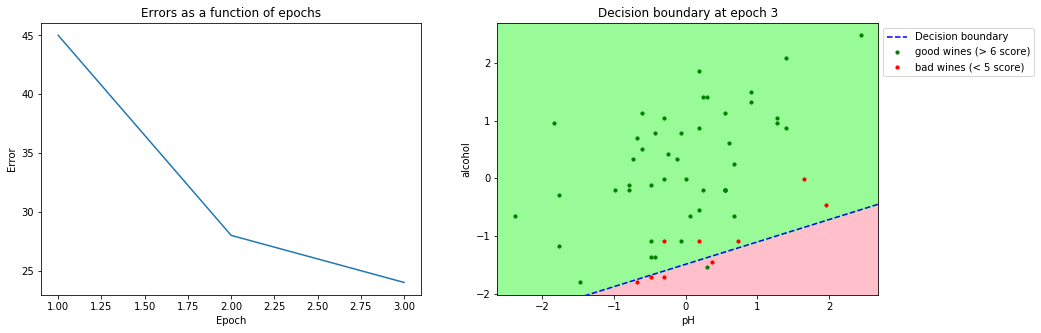

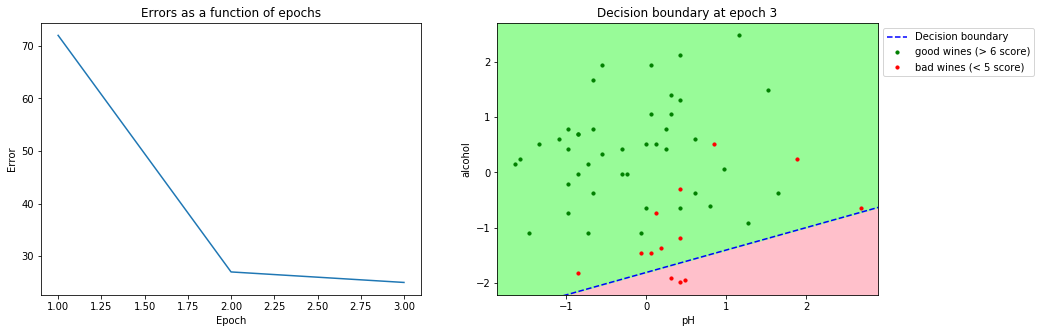

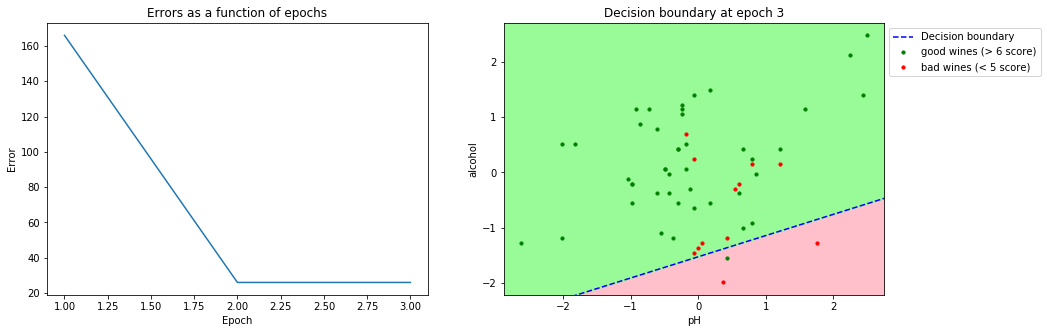

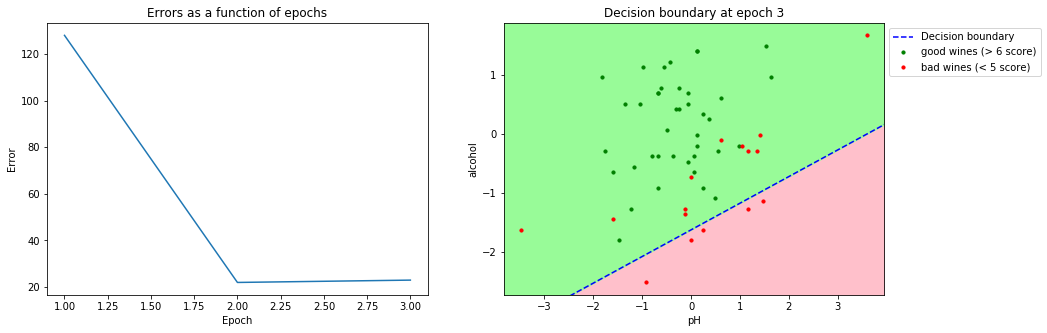

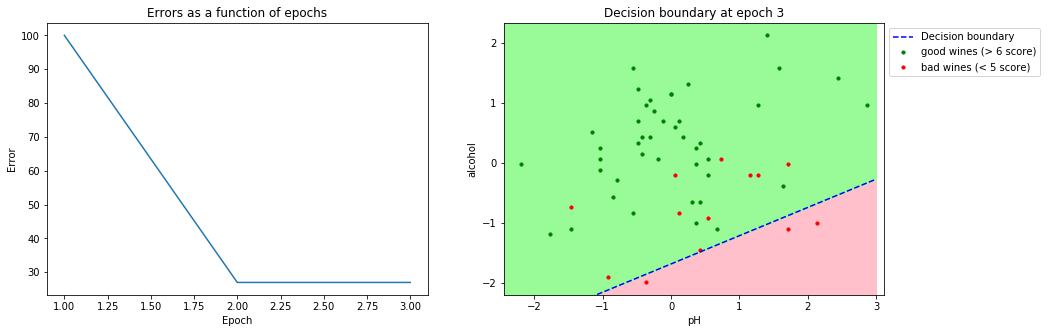

In [46]:
# Adaline batch: 'pH', 'alcohol', 'density', 'volatile acidity'
adaline_training_process("winequality-red.csv", ['pH', 'alcohol', 'density', 'volatile acidity'], 7, 4, False, 0.80, search_lr=[30, 0.01, 0.00001], k=5, plot=True)

Start Train Adaline, factor: ['pH', 'alcohol', 'density', 'volatile acidity'], good: 7, bad: 4, target accuracy: 0.8
Standardization data...complete
Start searching best learning rate
Round: 0, learning rate:0.0009744...Model converge at curEpoch: 3, accuracy: 0.889286, errorNumber: 31
Round: 1, learning rate:0.0065171...Model diverge at curEpoch: 3, accuracy: 0.889286, errorNumber: 31
Round: 2, learning rate:0.0011211...Model converge at curEpoch: 3, accuracy: 0.889286, errorNumber: 31
Round: 3, learning rate:0.0014312...Model converge at curEpoch: 3, accuracy: 0.889286, errorNumber: 31
Round: 4, learning rate:0.0018732...Model converge at curEpoch: 3, accuracy: 0.889286, errorNumber: 31
Round: 5, learning rate:0.0057526...Model converge at curEpoch: 3, accuracy: 0.889286, errorNumber: 31
Round: 6, learning rate:0.0037102...Model converge at curEpoch: 3, accuracy: 0.889286, errorNumber: 31
Round: 7, learning rate:0.0024924...Model converge at curEpoch: 3, accuracy: 0.889286, errorNumb

/Users/42robotics/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:92: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


k: 2, correct: 52
k: 3, correct: 52
k: 4, correct: 50
--------------------------------------------------------------
K fold cross validation complete, validaton result:
test set size: 56, mean: [50.], std: 2.121, Accuracy: [0.89285714]


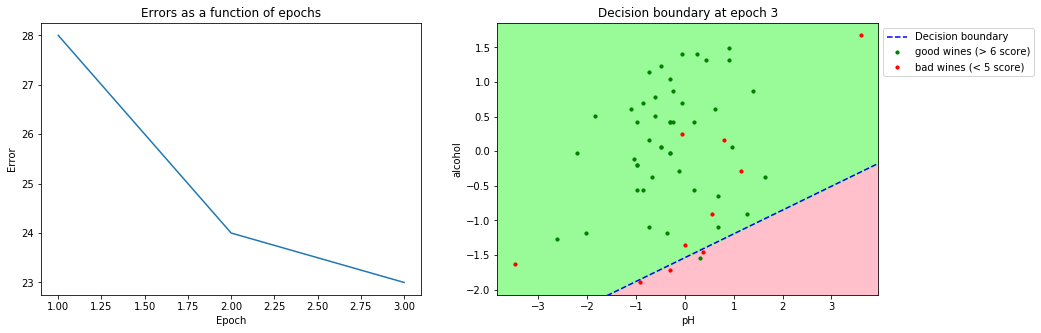

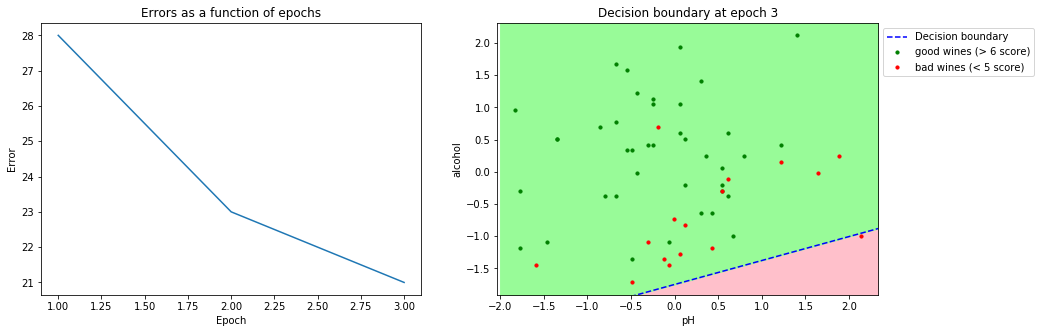

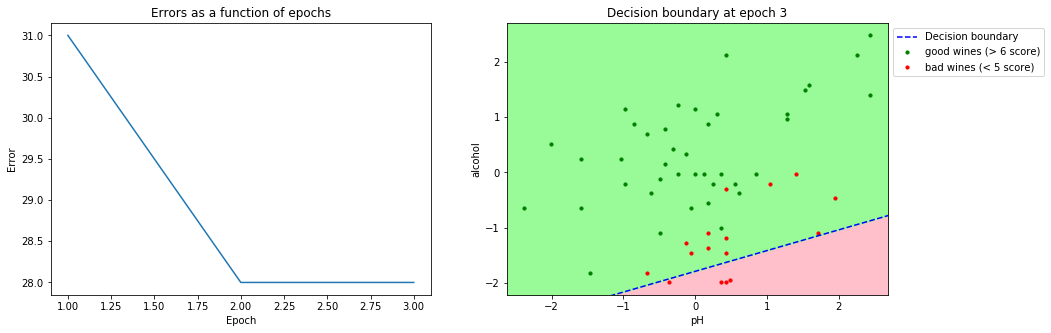

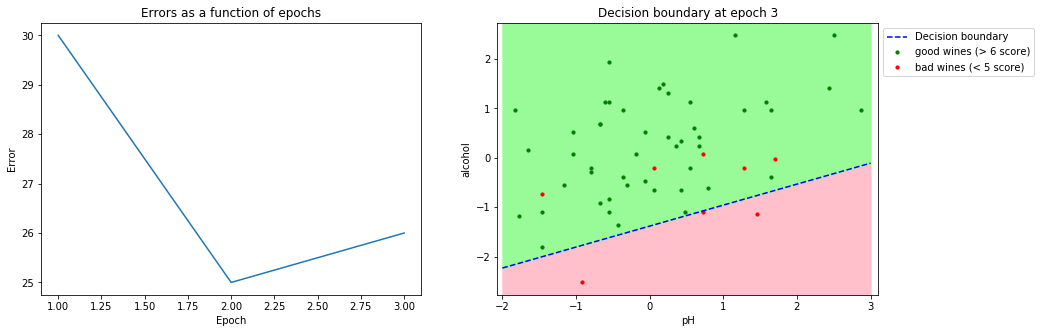

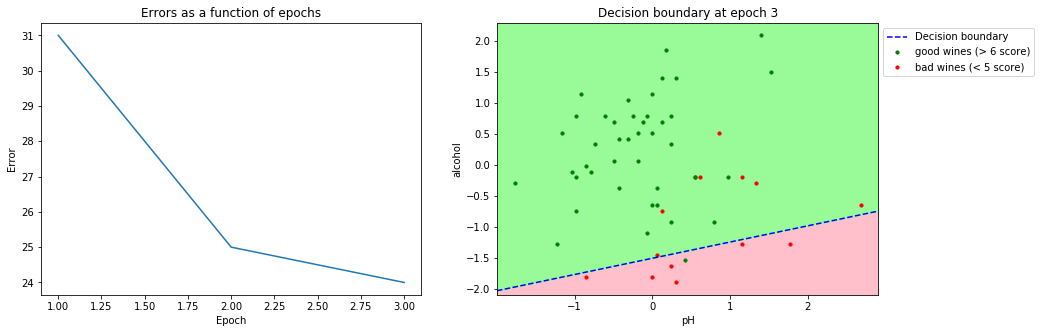

In [47]:
# Adaline online: 'pH', 'alcohol', 'density', 'volatile acidity'
adaline_training_process("winequality-red.csv", ['pH', 'alcohol', 'density', 'volatile acidity'], 7, 4, True, 0.80, search_lr=[30, 0.01, 0.00001], k=5, plot=True)

## b) What does the decision boundary for more then 2 factors look like?

### three dimension 
https://www.projectrhea.org/rhea/images/thumb/2/22/Hyperplane.png/700px-Hyperplane.png
### More then three dimension
https://i.ytimg.com/vi/Ze8Ts45LVdg/maxresdefault.jpg

# V.6 Marvin’s rebuttal

## a) Classify the Pan-Galactic Gargle Blaster dataset.

## Not working yet...

In [ ]:
pd.read_csv("Pan Galactic Gargle Blaster.csv", delimiter=";")

In [ ]:
adaline_training_process("Pan Galactic Gargle Blaster.csv", ['wonderflonium', 'fallian marsh gas'], 6, 5, False, 0.5, search_lr=[30, 0.01, 0.00001], k=10, plot=True)

# VI.2 Do perceptrons dream of electric sheep?

## Not working yet...